In [54]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir("drive/MyDrive/Colab Notebooks/Authorship Identification/")

import heapq
import warnings
import numpy as np
import pandas as pd
from scipy import sparse
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

random_seed = 42
np.random.seed = 42

### Load C50 Dataset (if already loaded)

- this (original dataset) is 50 train - 50 test split

In [113]:
train_df = pd.read_csv('C50/train.csv')
test_df = pd.read_csv('C50/test.csv')

- this dataset is the original one with entity names removed

In [203]:
train_df = pd.read_csv('C50/train_noents.csv')
test_df = pd.read_csv('C50/test_noents.csv')
train_df.rename(columns={'text': 'content', 'label': 'author'}, inplace=True)
test_df.rename(columns={'text': 'content', 'label': 'author'}, inplace=True)

- this is 90 train - 10 test split

In [3]:
test_frac = 0.1
train_df = pd.concat([train_df, test_df])
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index)

### Load "All the News" 1 Dataset

In [186]:
test_frac = 0.15
train_df = pd.read_csv('All the News/articles1.csv') # or articles1/all_the_news1_noents_notwitter
train_df = train_df[(train_df.publication == 'Breitbart')]
top10_authors = train_df[['author','id']].groupby('author').count().sort_values(by='id', ascending=False).head(10).reset_index() # this == what the paper proposed
print('The authors are', top10_authors.author.values)
train_df = pd.merge(train_df, top10_authors[['author']], on='author', how='right')
train_df = train_df.groupby(by='author').sample(500, random_state=random_seed)
test_df = train_df.sample(frac=test_frac, random_state=random_seed)
train_df = train_df.drop(test_df.index).reset_index()
test_df = test_df.reset_index()

The authors are ['Breitbart News' 'Pam Key' 'Charlie Spiering' 'Jerome Hudson'
 'John Hayward' 'Daniel Nussbaum' 'AWR Hawkins' 'Ian Hanchett'
 'Joel B. Pollak' 'Alex Swoyer']


### Preprocessing

In [204]:
le = preprocessing.LabelEncoder()
le.fit(train_df['author'])
author_names = le.classes_
train_df['author_id'] = le.transform(train_df['author']).astype(int)
test_df['author_id'] = le.transform(test_df['author']).astype(int)
y_train = train_df['author_id']
y_test = test_df['author_id']

In [205]:
train_df.head()

,content,author,author_id
0,"The capital market, roundly criticised for a l...",1,1
1,beat the Republic 3-0 in a ice hockey game on ...,1,1
2,The fall in the trade deficit to crowns in fro...,1,1
3,paper concern a.s. on said its net profit fell...,1,1
4,shares rallied on following the coalition gove...,1,1


In [135]:
# not used for linear models (nb, lr)
# valid_frac = 0.1 / (1 - test_frac)
# valid_df = train_df.sample(frac=valid_frac, random_state=random_seed)
# train_df = train_df.drop(valid_df.index)

In [218]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False) #, stop_words='english')
# tmp_df = pd.concat([train_df, test_df])
# tmp_df = tmp_df[tmp_df['author_id'] == 1]
X_train = vectorizer.fit_transform(train_df['content'])
X_test = vectorizer.transform(test_df['content'])
feat_names = vectorizer.get_feature_names_out()
feat_idf = vectorizer.idf_
X_train.shape, X_test.shape, X_train.nnz, X_test.nnz, y_train.shape, y_test.shape

((2500, 325306), (2500, 325306), 1432297, 1164800, (2500,), (2500,))

In [219]:
tfidf_df = pd.DataFrame(np.concatenate([feat_names[:,None], feat_idf[:,None]], axis=1), 
                        columns=['feat_name', 'feat_idf']).sort_values(by='feat_idf')
tfidf_df.tail(10)

,feat_name,feat_idf
158093,into expansion,8.131299
158094,into expect,8.131299
158095,into expecting,8.131299
158096,into exploration,8.131299
158097,into extreme,8.131299
158099,into factory,8.131299
158101,into fierce,8.131299
158102,into fighting,8.131299
158085,into energy,8.131299
325305,zoomed in,8.131299


### From 11/03 Discussion: Remove Top-k IDF Words from documents

In [155]:
def calc_tokens_removed(idf_split):
    full = TfidfVectorizer(ngram_range=(1, 2), lowercase=False).build_analyzer()
    remove_words = feat_names[feat_idf >= idf_split].tolist()
    remove = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words=remove_words).build_analyzer()
    full_len = train_df['content'].apply(lambda text: len(full(text))).to_numpy()
    remove_len = train_df['content'].apply(lambda text: len(remove(text))).to_numpy()
    return np.mean((full_len - remove_len)/full_len)

def remove_topk_df(train, test, percent=None, threshold=None, print_tokens=False):
    if percent is not None:
        k = int(len(feat_names) * percent)
        unmask = feat_idf.argpartition(-k)[:-k]
        threshold = max(feat_idf[unmask])
    elif threshold is not None:
        unmask = np.where(feat_idf < threshold)[0]
        percent = (len(feat_idf) - len(unmask)) / len(feat_idf)
    token_percent = calc_tokens_removed(threshold) if print_tokens else 0.
    print('{:.2%} feature types removed, >= IDF value of {:.2f} removed, {:.2%} tokens removed'.format(percent, threshold, token_percent))
    remove_words = feat_names[feat_idf >= threshold].tolist()
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=False, stop_words=remove_words)
    train2 = vectorizer.fit_transform(train_df['content'])
    test2 = vectorizer.transform(test_df['content'])
    feat_names2 = vectorizer.get_feature_names_out()
    feat_idf2 = vectorizer.idf_
    return train2, test2, feat_names2, feat_idf2
    # diag = sparse.eye(mat.shape[1]).tolil()
    # for c in mask:
    #   diag[c, c] = 0
    # return mat.dot(diag)

In [172]:
# run this only once for testing/visualization
X_train, X_test, feat_names, feat_idf = remove_topk_df(X_train, X_test, percent=None, threshold=2, print_tokens=False)
X_train.shape, X_test.shape, feat_names.shape, feat_idf.shape

99.99% feature types removed, >= IDF value of 2.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['He', 'It', 'The', 'Twitter', 'about', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', 'do', 'for', 'from', 'had', 'has', 'have', 'he', 'him', 'his', 'in', 'is', 'it', 'not', 'of', 'on', 'or', 'out', 'people', 'said', 'that', 'the', 'their', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'would', 'you'] not in stop_words.
  warnings.warn(


((4250, 2799), (750, 2799), (2799,), (2799,))

In [173]:
tfidf_df = pd.DataFrame(np.concatenate([feat_names[:,None], feat_idf[:,None]], axis=1), 
                        columns=['feat_name', 'feat_idf']).sort_values(by='feat_idf')
tfidf_df.tail(10)

,feat_name,feat_idf
173,Twitter out,8.661762
174,Twitter people,8.661762
2338,were can,8.661762
1086,had will,8.661762
2529,which which,8.661762
2273,we Twitter,8.661762
179,Twitter who,8.661762
180,Twitter with,8.661762
1200,he Twitter,8.661762
181,Twitter you,8.661762


### 1. Naive Bayes Classifier

In [191]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_nb = clf.predict(X_test)
feat_nb = np.exp(clf.feature_log_prob_)
feat_df_nb = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_nb.shape[0]):
    feat_df_nb[author_names[i]] = feat_nb[i,:]
feat_df_nb.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000009,0.000002
1,00 AM,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
2,00 AWR,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
3,00 American,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
4,00 At,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


### 2. SGD Classifier

In [192]:
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
clf.fit(X_train, y_train)
y_sgd = clf.predict(X_test)
feat_sgd = clf.coef_
feat_df_sgd = pd.DataFrame(feat_names, columns=['word'])
for i in range(feat_sgd.shape[0]):
    feat_df_sgd[author_names[i]] = feat_sgd[i,:]
feat_df_sgd.head()

,word,AWR Hawkins,Alex Swoyer,Breitbart News,Charlie Spiering,Daniel Nussbaum,Ian Hanchett,Jerome Hudson,Joel B. Pollak,John Hayward,Pam Key
0,00,-0.508078,-2.435922,-1.440751,-1.247868,-1.009477,-1.503332,-0.264613,-1.818640,11.561065,-2.653684
1,00 AM,-0.041481,-0.005741,0.179287,-0.002810,-0.139957,-0.007267,0.063134,-0.015392,-0.055382,-0.022046
2,00 AWR,0.069215,-0.001021,-0.009716,-0.001211,-0.009320,-0.002424,-0.003005,-0.005273,-0.011979,-0.002844
3,00 American,-0.000007,-0.004719,0.016077,-0.000928,-0.002750,-0.000012,-0.000023,-0.000588,-0.000235,-0.000843
4,00 At,-0.000003,-0.001787,0.009851,-0.000026,-0.000009,-0.000038,-0.000246,-0.000840,-0.000496,-0.000121


### Evaluate

In [193]:
def eval_all(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print('accuracy:', accuracy, '   precision:', precision, '   recall:', recall, '   f1_macro:', f1_macro)
    return accuracy, f1_macro

In [194]:
print('Naive Bayes Result')
eval_all(y_test, y_nb)
print('SGD Classifier Result')
eval_all(y_test, y_sgd)

Naive Bayes Result
accuracy: 0.6453333333333333    precision: 0.8775564125611691    recall: 0.6382068849072366    f1_macro: 0.6704288984179689
SGD Classifier Result
accuracy: 0.9386666666666666    precision: 0.9366086479130088    recall: 0.9416451982867716    f1_macro: 0.9375560171208921


(0.9386666666666666, 0.9375560171208921)

### Grid Search in Removing Top-k IDF Words vs. Performances

In [142]:
def grid_search_idf(threshold_list, nb_path, lr_path):
    
    index_list = []
    nb_train_accs, nb_test_accs, nb_train_f1s, nb_test_f1s = [], [], [], []
    lr_train_accs, lr_test_accs, lr_train_f1s, lr_test_f1s = [], [], [], []
    
    nb_clf = MultinomialNB()
    lr_clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
    
    for threshold in threshold_list:
        
        warnings.filterwarnings(action='once')
        X_train2, X_test2, _, _ = remove_topk_df(X_train, X_test, threshold=threshold)
        nb_clf.fit(X_train2, y_train)
        lr_clf.fit(X_train2, y_train)
        y_nb_train = nb_clf.predict(X_train2)
        y_lr_train = lr_clf.predict(X_train2)
        y_nb_test = nb_clf.predict(X_test2)
        y_lr_test = lr_clf.predict(X_test2)
        nb_train_acc, nb_train_f1 = eval_all(y_train, y_nb_train)
        lr_train_acc, lr_train_f1 = eval_all(y_train, y_lr_train)
        nb_test_acc, nb_test_f1 = eval_all(y_test, y_nb_test)
        lr_test_acc, lr_test_f1 = eval_all(y_test, y_lr_test)
        
        index_list.append(threshold)
        nb_train_accs.append(nb_train_acc)
        nb_test_accs.append(nb_test_acc)
        nb_train_f1s.append(nb_train_f1)
        nb_test_f1s.append(nb_test_f1)
        lr_train_accs.append(lr_train_acc)
        lr_test_accs.append(lr_test_acc)
        lr_train_f1s.append(lr_train_f1)
        lr_test_f1s.append(lr_test_f1)
    
    nb_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    nb_df['train_accs'] = nb_train_accs
    nb_df['train_f1s'] = nb_train_f1s
    nb_df['test_accs'] = nb_test_accs
    nb_df['test_f1s'] = nb_test_f1s
    nb_df['model_name'] = 'nb'
    nb_df.to_csv(nb_path + '.csv', index=False)
    
    lr_df = pd.DataFrame(index_list, columns=['idf_threshold'])
    lr_df['train_accs'] = lr_train_accs
    lr_df['train_f1s'] = lr_train_f1s
    lr_df['test_accs'] = lr_test_accs
    lr_df['test_f1s'] = lr_test_f1s
    lr_df['model_name'] = 'lr'
    lr_df.to_csv(lr_path + '.csv', index=False)
    return (nb_train_accs, nb_train_f1s, nb_test_accs, nb_test_f1s), (lr_train_accs, lr_train_f1s, lr_test_accs, lr_test_f1s)

def plot_idf(nb_path, lr_path, bert_path):
    nb_df = pd.read_csv(nb_path + '.csv')
    lr_df = pd.read_csv(lr_path + '.csv')
    bert_df = pd.read_csv(bert_path + '.csv')
    threshold_list = nb_df['idf_threshold']
    metric_ls = [('nb', nb_df['train_accs'], nb_df['test_accs'], nb_df['train_f1s'], nb_df['test_f1s']), 
                 ('lr', lr_df['train_accs'], lr_df['test_accs'], lr_df['train_f1s'], lr_df['test_f1s']),
                 ('bert', bert_df['train_accs'], bert_df['test_accs'], bert_df['train_f1s'], bert_df['test_f1s'])]
    category_colors = plt.get_cmap('brg')(np.linspace(0., 1., len(metric_ls)))
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    plt.xticks(rotation=0)
    axs.flatten()
    xrange = range(len(threshold_list))
    for (metric_name, train_acc, test_acc, train_f1, test_f1), color in zip(metric_ls, category_colors):
        axs[0].set_xticklabels(threshold_list)
        axs[0].set_xticks(xrange)
        axs[0].plot(xrange, train_acc, 'o--', color=color)
        axs[0].plot(xrange, test_acc, 'o-', color=color, label=metric_name + ' accuracy')
        axs[0].set_xlabel('IDF threshold')
        axs[0].set_ylabel('accuracy')
        axs[0].grid(axis='x', color='0.75')
        axs[0].legend()
        
        axs[1].set_xticklabels(threshold_list)
        axs[1].set_xticks(xrange)
        axs[1].plot(xrange, train_f1, 'o--', color=color)
        axs[1].plot(xrange, test_f1, 'o-', color=color, label=metric_name + ' F1 score')
        axs[1].set_xlabel('IDF threshold')
        axs[1].set_ylabel('F1 score')
        axs[1].grid(axis='x', color='0.75')
        axs[1].legend()
    plt.show()

In [143]:
grid_search_idf(threshold_list=np.arange(10., 1., -0.5), nb_path='All the News/result/nb_model2', lr_path='All the News/result/lr_model2')

0.00% feature types removed, >= IDF value of 10.00 removed, 0.00% tokens removed
accuracy: 0.7604705882352941    precision: 0.9249549034925539    recall: 0.760542313950972    f1_macro: 0.7994479515651056
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.432    precision: 0.828895431834404    recall: 0.42407489347240945    f1_macro: 0.42973505360248554
accuracy: 0.9053333333333333    precision: 0.9042224529001561    recall: 0.9052073418443662    f1_macro: 0.9012477023254718
0.00% feature types removed, >= IDF value of 9.50 removed, 0.00% tokens removed
accuracy: 0.7604705882352941    precision: 0.9249549034925539    recall: 0.760542313950972    f1_macro: 0.7994479515651056
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.432    precision: 0.828895431834404    recall: 0.42407489347240945    f1_macro: 0.42973505360248554
accuracy: 0.9053333333333333    precision: 0.9042224529001561    recall: 0.9052073418443662    f1_macro: 0.9012477023

/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '00pm', '01', '02', '03', '04', '04pm', '05', '06', '07', '08', '09', '10', '100', '101', '10PM', '11', '110', '1182', '12', '13', '14', '14pm', '15', '16', '17', '18', '19', '19am', '1st', '20', '2004', '2014', '2016', '20s', '21', '22', '23', '2334', '24', '25', '26', '27', '27pm', '28', '29', '30', '30s', '31', '32', '33', '33pm', '34', '35', '35pm', '36', '360', '365', '37', '38', '39', '40', '405', '41', '42', '43', '44', '45', '45am', '46', '47', '48', '49', '49ers', '50', '50pm', '51', '52', '53', '54', '55', '56', '57', '58', '59', '59pm', '600', '75', '800', '88th', '90', '900', '93', '94', '99', '9AM', 'A2020', 'AA', 'AB', 'ABC', 'ABC15', 'ABC7', 'ABCLiz', 'ABCNetwork', 'ABCPolitics', 'ABFalecbaldwin', 'ABFoundation', 'ABOUT', 'AC360', 'ACA', 'ACTION',

accuracy: 0.7574117647058823    precision: 0.9246543652208793    recall: 0.7575093556516156    f1_macro: 0.7968456451330279
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43466666666666665    precision: 0.8272403829567017    recall: 0.42695393241192897    f1_macro: 0.4330827835770517
accuracy: 0.9093333333333333    precision: 0.9073461189318843    recall: 0.9092330670769879    f1_macro: 0.9052252071639414
83.26% feature types removed, >= IDF value of 8.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '101', '10PM', '11', '1182', '12', '13', '14', '15', '16', '17', '18', '19', '1st', '20', '2014', '2016', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '30s', '31', '32', '33', '34', '35', '36', '360', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '49ers', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '75', '88th', '90', '900', '99', '9AM', 'A2020', 'AB', 'ABC', 'ABC15', 'ABC7', 'ABCLiz', 'ABCPolitics', 'ABFalecbaldwin', 'ABFoundation', 'AC360', 'ACA', 'AFP', 'AGAIN', 'AGAINST', 'AIDS', 'AIPAC', 'ALL', 'AM', 'AMERICA', 'AMPAS', 'AND', 'ANY', 'AP', 'AR', 'ARE', 'ASAP', 'ASwoyer', 'AT', 'ATF', 'AZ', 'AaronBlake', 'Abortion', 'About', 'Abov

accuracy: 0.7522352941176471    precision: 0.9241644009956642    recall: 0.7523156488917028    f1_macro: 0.7923721200506518
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43466666666666665    precision: 0.8272403829567017    recall: 0.42695393241192897    f1_macro: 0.4330827835770517
accuracy: 0.9106666666666666    precision: 0.9088274718457289    recall: 0.910498889861798    f1_macro: 0.9065539460491969
92.24% feature types removed, >= IDF value of 7.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2016', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '49ers', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '900', '9AM', 'ABC', 'ABCLiz', 'ABCPolitics', 'AFP', 'ALL', 'AM', 'AMPAS', 'AND', 'ANY', 'AP', 'ATF', 'About', 'Absolutely', 'Academy', 'According', 'Acosta', 'Act', 'Acting', 'Action', 'Actor', 'Actors', 'Actress', 'Actually', 'Adams', 'Additional', 'Additionally', 'Administration', 'Adviser', 'Advisor', 'After', 'Again', 'Against', 'Agent', 'Ailes', 'Air', 'Aleppo', 'All', 'Allah', 'Allahu', 'Alm

accuracy: 0.7362352941176471    precision: 0.9220063610727145    recall: 0.7363729358107498    f1_macro: 0.7782149543321335
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43333333333333335    precision: 0.8333544258617671    recall: 0.4260435682662707    f1_macro: 0.43136863874385095
accuracy: 0.9066666666666666    precision: 0.9044300756127553    recall: 0.9065606232127774    f1_macro: 0.9026173374099166
95.42% feature types removed, >= IDF value of 7.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '01', '02', '03', '04', '05', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '2016', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '32', '33', '35', '36', '37', '39', '40', '41', '42', '43', '45', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '9AM', 'ABC', 'ABCLiz', 'ABCPolitics', 'ALL', 'AM', 'AND', 'AP', 'About', 'Absolutely', 'Academy', 'According', 'Act', 'Action', 'Actor', 'Actress', 'Actually', 'Additionally', 'Administration', 'Adviser', 'Advisor', 'After', 'Again', 'Against', 'All', 'Allah', 'Along', 'Already', 'Also', 'Although', 'Am', 'Ambassador', 'Amendment', 'America', 'American', 'Among', 'An', 'Analyst', 'And', 'Another', 'Any', 'Anyone', 'Anything', 'Apparently', 'Are', 

accuracy: 0.7209411764705882    precision: 0.9199987009842884    recall: 0.7211325734041855    f1_macro: 0.7644988541957671
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.428    precision: 0.8416202111031634    recall: 0.4202854903872318    f1_macro: 0.4241420314376273
accuracy: 0.912    precision: 0.9099208850613424    recall: 0.9117070226184796    f1_macro: 0.908174650074361
97.34% feature types removed, >= IDF value of 6.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '02', '05', '07', '08', '09', '10', '11', '12', '15', '18', '20', '21', '22', '23', '25', '26', '27', '30', '33', '35', '37', '40', '42', '45', '50', '53', '55', '58', '9AM', 'ABC', 'ABCPolitics', 'AM', 'About', 'Absolutely', 'Academy', 'According', 'Act', 'Action', 'Actor', 'Actress', 'Actually', 'Additionally', 'Administration', 'Adviser', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'Amendment', 'America', 'Among', 'An', 'And', 'Another', 'Any', 'Anyone', 'Apparently', 'Are', 'As', 'Asked', 'Assistant', 'At', 'Attorney', 'Authorities', 'Awards', 'BREAKING', 'Based', 'Be', 'Beast', 'Because', 'Before', 'Below', 'BernieSanders', 'Best', 'Big', 'Bill', 'Black', 'Both', 'But', 'By', 'CEO', 'CNN', 'Call', 'Campaign', 'Can', 'Captain', 'Cash', 'Chairm

accuracy: 0.704    precision: 0.9184931676778314    recall: 0.7043496815869885    f1_macro: 0.7493711218854441
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.428    precision: 0.8451290388766971    recall: 0.42034221188467924    f1_macro: 0.42331418667205273
accuracy: 0.9106666666666666    precision: 0.9088353441205435    recall: 0.9111253170042799    f1_macro: 0.9068088836155471
98.39% feature types removed, >= IDF value of 6.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['00', '000', '05', '10', '11', '12', '15', '20', '25', '30', '40', '45', '9AM', 'About', 'Absolutely', 'According', 'Act', 'Actor', 'Actually', 'Adviser', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'Amendment', 'America', 'Among', 'An', 'And', 'Another', 'Any', 'Anyone', 'Are', 'As', 'Asked', 'At', 'Attorney', 'Be', 'Because', 'Before', 'Below', 'BernieSanders', 'Best', 'Big', 'Black', 'Both', 'But', 'By', 'CEO', 'CNN', 'Campaign', 'Can', 'Cash', 'Chairman', 'Channel', 'Chief', 'Congressman', 'Daily', 'Day', 'Deputy', 'Despite', 'Did', 'Director', 'Do', 'Does', 'Don', 'Dr', 'During', 'EST', 'Earnest', 'Editor', 'Even', 'Every', 'Everybody', 'Everyone', 'Evil', 'Facebook', 'First', 'Follow', 'Following', 'For', 'Foreign', 'Former', 'From', 'General', 'Get', 'G

accuracy: 0.6814117647058824    precision: 0.9161388093561907    recall: 0.6817791617180972    f1_macro: 0.7292536294262155
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.43066666666666664    precision: 0.8479620455147232    recall: 0.4232833883552676    f1_macro: 0.42738743473296853
accuracy: 0.912    precision: 0.9086594569704458    recall: 0.9117717331021915    f1_macro: 0.9075973829221781
99.04% feature types removed, >= IDF value of 5.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['000', '10', 'About', 'According', 'Actor', 'After', 'Again', 'All', 'Also', 'Although', 'Ambassador', 'America', 'Among', 'An', 'And', 'Another', 'Are', 'As', 'Asked', 'At', 'Attorney', 'Because', 'Before', 'Black', 'Both', 'But', 'By', 'CEO', 'Can', 'Chairman', 'Chief', 'Congressman', 'Despite', 'Did', 'Director', 'Do', 'Does', 'Don', 'Dr', 'During', 'EST', 'Editor', 'Even', 'Every', 'Evil', 'Facebook', 'First', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Good', 'Gov', 'Governor', 'Great', 'Handle', 'Hard', 'He', 'Her', 'Here', 'Hey', 'His', 'How', 'However', 'If', 'In', 'Indeed', 'Inside', 'Instead', 'Internet', 'Is', 'It', 'Judge', 'Just', 'Justice', 'Later', 'Leader', 'Left', 'Let', 'Like', 'Listen', 'Live', 'Lives', 'Look', 'Majority', 'Make', 'Many', 'Matter

accuracy: 0.6538823529411765    precision: 0.9124103978483344    recall: 0.6543478418914987    f1_macro: 0.7035382723960306
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.428    precision: 0.8396575169345869    recall: 0.41986414849784437    f1_macro: 0.42077229967452656
accuracy: 0.8946666666666667    precision: 0.8913520862881079    recall: 0.8951846239859259    f1_macro: 0.8904075854418091
99.43% feature types removed, >= IDF value of 5.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'Again', 'All', 'Also', 'America', 'An', 'And', 'Another', 'As', 'At', 'Attorney', 'Because', 'Black', 'Both', 'But', 'By', 'CEO', 'Can', 'Chairman', 'Chief', 'Director', 'Do', 'Don', 'Dr', 'During', 'Even', 'Evil', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Gov', 'Governor', 'Handle', 'Hard', 'He', 'Her', 'Here', 'His', 'How', 'However', 'If', 'In', 'Inside', 'Instead', 'Internet', 'Is', 'It', 'Just', 'Leader', 'Left', 'Let', 'Lives', 'Look', 'Many', 'Matter', 'Maybe', 'Minister', 'More', 'Mr', 'My', 'No', 'Not', 'Now', 'Of', 'Oh', 'On', 'Or', 'Other', 'Our', 'Partial', 'People', 'Police', 'President', 'Prime', 'Reach', 'Read', 'Rep', 'Reporter', 'Revolution', 'Right', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 

accuracy: 0.6225882352941177    precision: 0.901553350314801    recall: 0.6230547422490337    f1_macro: 0.6714969797386392
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.4026666666666667    precision: 0.7969758158282303    recall: 0.3951299930003545    f1_macro: 0.3858028677701643
accuracy: 0.8973333333333333    precision: 0.8931846973966469    recall: 0.897083494495012    f1_macro: 0.8932616513845935
99.66% feature types removed, >= IDF value of 4.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'All', 'And', 'As', 'At', 'Because', 'Black', 'But', 'By', 'CEO', 'Can', 'Director', 'Do', 'Dr', 'During', 'Even', 'Evil', 'Follow', 'For', 'Former', 'From', 'General', 'God', 'Gov', 'Governor', 'Handle', 'Hard', 'He', 'Here', 'His', 'How', 'However', 'If', 'In', 'Inside', 'Is', 'It', 'Just', 'Left', 'Let', 'Look', 'Mr', 'My', 'No', 'Not', 'Now', 'Of', 'On', 'Our', 'People', 'President', 'Reach', 'Read', 'Rep', 'Revolution', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 'Some', 'Speaker', 'State', 'Story', 'TV', 'That', 'The', 'There', 'These', 'They', 'This', 'Those', 'To', 'Trump', 'Twitter', 'Vice', 'We', 'Well', 'What', 'When', 'While', 'Why', 'With', 'Won', 'You', 'ability', 'able', 'about', 'above', 'absolutely', 'access

accuracy: 0.5915294117647059    precision: 0.8997240831796866    recall: 0.5920047784970082    f1_macro: 0.6402353818952972
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.4013333333333333    precision: 0.7924607322861943    recall: 0.3935006746063302    f1_macro: 0.38176449190890127
accuracy: 0.8906666666666667    precision: 0.8859623518634303    recall: 0.8909693500018495    f1_macro: 0.8866636583953168
99.82% feature types removed, >= IDF value of 4.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'After', 'All', 'And', 'As', 'At', 'Because', 'But', 'Can', 'During', 'Follow', 'For', 'From', 'He', 'His', 'How', 'However', 'If', 'In', 'It', 'Left', 'Let', 'Mr', 'My', 'No', 'Now', 'On', 'President', 'Reach', 'Secretary', 'See', 'Sen', 'Senator', 'Senior', 'She', 'SiriusXM', 'So', 'That', 'The', 'There', 'These', 'They', 'This', 'To', 'Trump', 'Twitter', 'We', 'Well', 'What', 'When', 'While', 'You', 'able', 'about', 'according', 'across', 'action', 'actually', 'added', 'adding', 'administration', 'after', 'again', 'against', 'ahead', 'airs', 'all', 'allowed', 'along', 'already', 'also', 'always', 'am', 'among', 'an', 'analyst', 'and', 'announced', 'another', 'any', 'anyone', 'anything', 'appeared', 'are', 'argued', 'around', 'as', 'ask', 'asked', 'asking', 'a

accuracy: 0.5557647058823529    precision: 0.8962622477590771    recall: 0.5562472725614952    f1_macro: 0.6040289967433068
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.3893333333333333    precision: 0.7727727064395385    recall: 0.3825249994967269    f1_macro: 0.37280942545540946
accuracy: 0.892    precision: 0.8892075692723956    recall: 0.8920981918535669    f1_macro: 0.8884247075108437
99.91% feature types removed, >= IDF value of 3.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['According', 'And', 'As', 'But', 'Follow', 'For', 'He', 'His', 'If', 'In', 'It', 'No', 'On', 'President', 'Reach', 'Secretary', 'Sen', 'Senior', 'She', 'So', 'That', 'The', 'There', 'They', 'This', 'Trump', 'Twitter', 'We', 'What', 'When', 'You', 'about', 'according', 'actually', 'added', 'administration', 'after', 'again', 'against', 'all', 'already', 'also', 'always', 'am', 'an', 'analyst', 'and', 'another', 'any', 'anything', 'are', 'around', 'as', 'asked', 'at', 'attack', 'available', 'away', 'back', 'be', 'because', 'been', 'before', 'behind', 'being', 'believe', 'best', 'better', 'between', 'big', 'book', 'both', 'broadcast', 'but', 'by', 'call', 'called', 'came', 'campaign', 'can', 'candidate', 'case', 'change', 'clear', 'columnist', 'com', 'come', 'comes', 'continued

accuracy: 0.5352941176470588    precision: 0.8803335905532578    recall: 0.5355829293186035    f1_macro: 0.5775795125655214
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.384    precision: 0.7518903491511147    recall: 0.37603512461915767    f1_macro: 0.36218503393746965
accuracy: 0.8693333333333333    precision: 0.8658305642788096    recall: 0.8691660306834773    f1_macro: 0.8651365839098546
99.95% feature types removed, >= IDF value of 3.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['And', 'As', 'But', 'Follow', 'He', 'If', 'In', 'It', 'On', 'President', 'She', 'So', 'That', 'The', 'There', 'They', 'This', 'Trump', 'Twitter', 'We', 'You', 'about', 'according', 'added', 'after', 'against', 'all', 'also', 'an', 'and', 'any', 'are', 'around', 'as', 'asked', 'at', 'back', 'be', 'because', 'been', 'before', 'being', 'both', 'but', 'by', 'called', 'campaign', 'can', 'candidate', 'come', 'could', 'country', 'did', 'didn', 'do', 'does', 'doesn', 'don', 'down', 'during', 'election', 'even', 'fact', 'for', 'former', 'from', 'get', 'go', 'going', 'good', 'got', 'government', 'had', 'has', 'have', 'he', 'her', 'here', 'him', 'his', 'host', 'how', 'if', 'in', 'including', 'interview', 'into', 'is', 'it', 'its', 'just', 'know', 'like', 'lot', 'made', 'make', 'many', 

accuracy: 0.5225882352941177    precision: 0.8648746769878543    recall: 0.5222488614271178    f1_macro: 0.5624057391451963
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.39066666666666666    precision: 0.7623846943120263    recall: 0.3875606649356442    f1_macro: 0.38397269872335466
accuracy: 0.8186666666666667    precision: 0.8157039079519406    recall: 0.8194773099330236    f1_macro: 0.8146197385445436
99.97% feature types removed, >= IDF value of 2.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['And', 'But', 'Follow', 'He', 'In', 'It', 'President', 'That', 'The', 'This', 'Twitter', 'We', 'about', 'added', 'after', 'against', 'all', 'also', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'being', 'but', 'by', 'campaign', 'can', 'could', 'country', 'did', 'do', 'don', 'during', 'even', 'for', 'from', 'get', 'going', 'had', 'has', 'have', 'he', 'her', 'him', 'his', 'how', 'if', 'in', 'into', 'is', 'it', 'just', 'know', 'like', 'made', 'make', 'media', 'more', 'most', 'new', 'no', 'not', 'now', 'of', 'on', 'one', 'or', 'other', 'our', 'out', 'over', 'people', 'political', 'president', 'presidential', 're', 'said', 'say', 'she', 'should', 'so', 'some', 'than', 'that', 'the', 'their', 'them', 'there', 'they', 'think', 'this', 'time', 'to', 'told', 'up', '

accuracy: 0.5875294117647059    precision: 0.8398345938761785    recall: 0.5866154359424278    f1_macro: 0.6106960747312136
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.46    precision: 0.7100772861909117    recall: 0.46092142506868605    f1_macro: 0.4542444623545296
accuracy: 0.7706666666666667    precision: 0.7709756665842316    recall: 0.7706007147301317    f1_macro: 0.768099532023873
99.99% feature types removed, >= IDF value of 2.00 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['He', 'It', 'The', 'Twitter', 'about', 'all', 'also', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', 'do', 'for', 'from', 'had', 'has', 'have', 'he', 'him', 'his', 'in', 'is', 'it', 'not', 'of', 'on', 'or', 'out', 'people', 'said', 'that', 'the', 'their', 'they', 'this', 'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'would', 'you'] not in stop_words.
  warnings.warn(


accuracy: 0.6941176470588235    precision: 0.7563203632938273    recall: 0.6931537112499834    f1_macro: 0.6873473235662596
accuracy: 1.0    precision: 1.0    recall: 1.0    f1_macro: 1.0
accuracy: 0.54    precision: 0.5782744540709439    recall: 0.5429713740403848    f1_macro: 0.5136968121198877
accuracy: 0.6733333333333333    precision: 0.6701917801573068    recall: 0.6721414563189306    f1_macro: 0.6673176071339262
100.00% feature types removed, >= IDF value of 1.50 removed, 0.00% tokens removed


/home/ys724/.conda/envs/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['The', 'and', 'as', 'at', 'be', 'by', 'for', 'from', 'have', 'he', 'in', 'is', 'it', 'not', 'of', 'on', 'said', 'that', 'the', 'to', 'was', 'with'] not in stop_words.
  warnings.warn(


accuracy: 0.552    precision: 0.558237975257373    recall: 0.5522654979739422    f1_macro: 0.5468761886814206
accuracy: 0.8432941176470589    precision: 0.8559916504729099    recall: 0.8442524361226686    f1_macro: 0.8457682082329867
accuracy: 0.508    precision: 0.48917371227310946    recall: 0.5067647669583256    f1_macro: 0.48633071185247045
accuracy: 0.5773333333333334    precision: 0.5877784179131281    recall: 0.5692485283656921    f1_macro: 0.5686112879619823


(([0.7604705882352941,
   0.7604705882352941,
   0.7604705882352941,
   0.7574117647058823,
   0.7522352941176471,
   0.7362352941176471,
   0.7209411764705882,
   0.704,
   0.6814117647058824,
   0.6538823529411765,
   0.6225882352941177,
   0.5915294117647059,
   0.5557647058823529,
   0.5352941176470588,
   0.5225882352941177,
   0.5875294117647059,
   0.6941176470588235,
   0.552],
  [0.7994479515651056,
   0.7994479515651056,
   0.7994479515651056,
   0.7968456451330279,
   0.7923721200506518,
   0.7782149543321335,
   0.7644988541957671,
   0.7493711218854441,
   0.7292536294262155,
   0.7035382723960306,
   0.6714969797386392,
   0.6402353818952972,
   0.6040289967433068,
   0.5775795125655214,
   0.5624057391451963,
   0.6106960747312136,
   0.6873473235662596,
   0.5468761886814206],
  [0.432,
   0.432,
   0.432,
   0.43466666666666665,
   0.43466666666666665,
   0.43333333333333335,
   0.428,
   0.428,
   0.43066666666666664,
   0.428,
   0.4026666666666667,
   0.401333333333

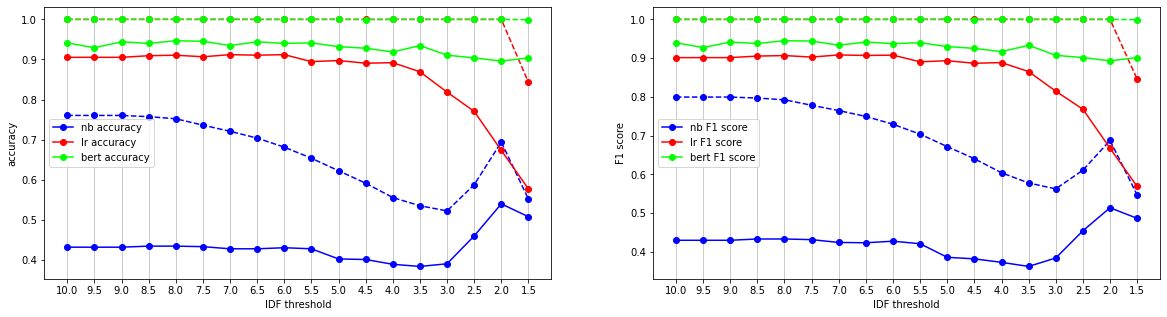

In [144]:
plot_idf(nb_path='All the News/result/nb_model2', lr_path='All the News/result/lr_model2', 
         bert_path='All the News/result/bert_uncased_epoch15_lr2e-5_batch16')

### Get TF-IDF Feat Values

In [195]:
def get_tfidf_feat(feat_df, feat_data, author_name, top_k=5, larger=True):
    idxs = feat_df.index[feat_df['author'] == author_name].tolist()
    feat_val = feat_data[idxs]
    word_val = feat_names
    n = feat_val.shape[0]
    word_array = []
    val_array = []
    for i in range(n):
        val_col = feat_val[i].toarray()[0]
        idxs = np.argsort(val_col)[-top_k:][::-1] if larger else np.argsort(val_col)[top_k:]
        words = word_val[idxs]
        vals = val_col[idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    sorted_idxs = np.argsort(-val_array.sum(axis=1))
    return word_array[sorted_idxs], val_array[sorted_idxs]

In [196]:
word_tfidf, val_tfidf = get_tfidf_feat(train_df, X_train, author_name='AWR Hawkins', top_k=5)

### Feature Importance Extraction

In [197]:
def get_feat_importance(feat_df, word_col, author_cols, top_k=5, larger=True):
    n = feat_df.shape[0]
    word_array = []
    val_array = []
    for author_col in author_cols:
        val_col = feat_df[author_col].values.take
        idxs = heapq.nlargest(top_k, range(n), val_col) if larger else heapq.nsmallest(top_k, range(n), val_col)
        words = feat_df[word_col][idxs]
        vals = feat_df[author_col][idxs]
        word_array.append(words)
        val_array.append(vals)
    word_array = np.array(word_array)
    val_array = np.array(val_array)
    return word_array, val_array
    # sorted_idxs = np.argsort(-val_array.sum(axis=1))
    # return word_array[sorted_idxs], val_array[sorted_idxs]

In [198]:
word_array_nb, val_array_nb = get_feat_importance(feat_df_nb, 'word', author_names, top_k=5)
word_array_sgd, val_array_sgd = get_feat_importance(feat_df_sgd, 'word', author_names, top_k=5)

### Feature Importance Visualization

In [199]:
def plot_feat_importance(word_array, val_array, author_cols, ycol_name):
    n, k = word_array.shape
    val_cum = val_array.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.25, 0.75, val_array.shape[1]))
    fig, ax = plt.subplots(figsize=(k*6, n//2))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(val_array, axis=1).max())
    for i, color in enumerate(category_colors):
        widthnames = word_array[:, i]
        widths = val_array[:, i]
        starts = val_cum[:, i] - widths
        ax.barh(author_cols, widths, left=starts, height=0.8, color=color)
        xcenters = starts + widths / 2
        for y, (x, name, val) in enumerate(zip(xcenters, widthnames, widths)):
            ax.text(x, y, name + ': ' + '{:.2f}'.format(val), ha='center', va='center', color='black')
    plt.ylabel(ycol_name)
    plt.title('top-' + str(k) + ' important word: importance values')
    plt.show()

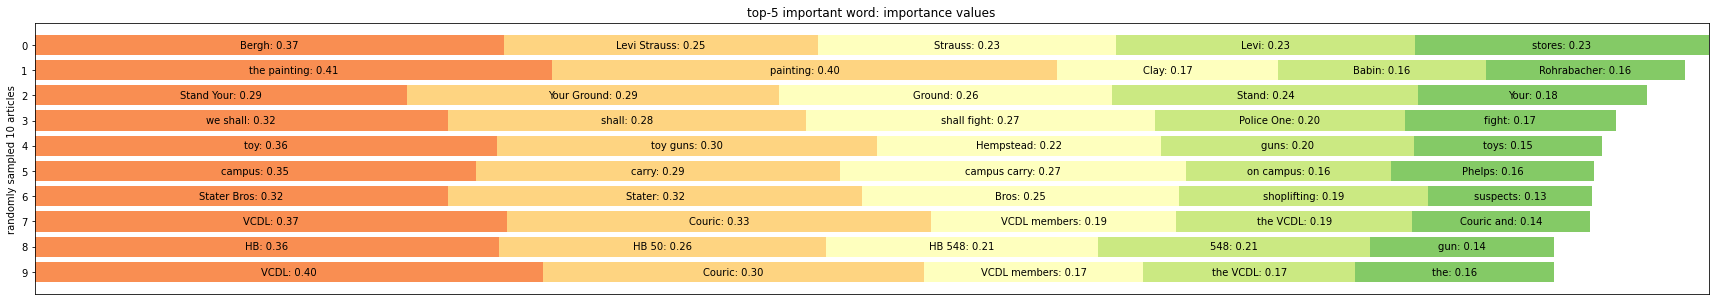

In [200]:
plot_feat_importance(word_tfidf[:10], val_tfidf[:10], [str(i) for i in range(10)], 'randomly sampled 10 articles')

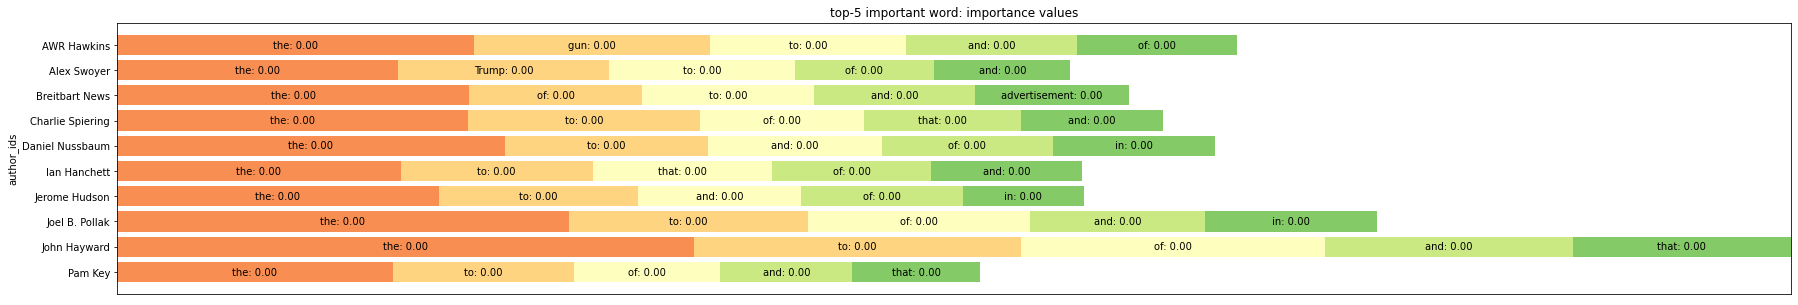

In [201]:
plot_feat_importance(word_array_nb[:10], val_array_nb[:10], author_names[:10], 'author_ids')

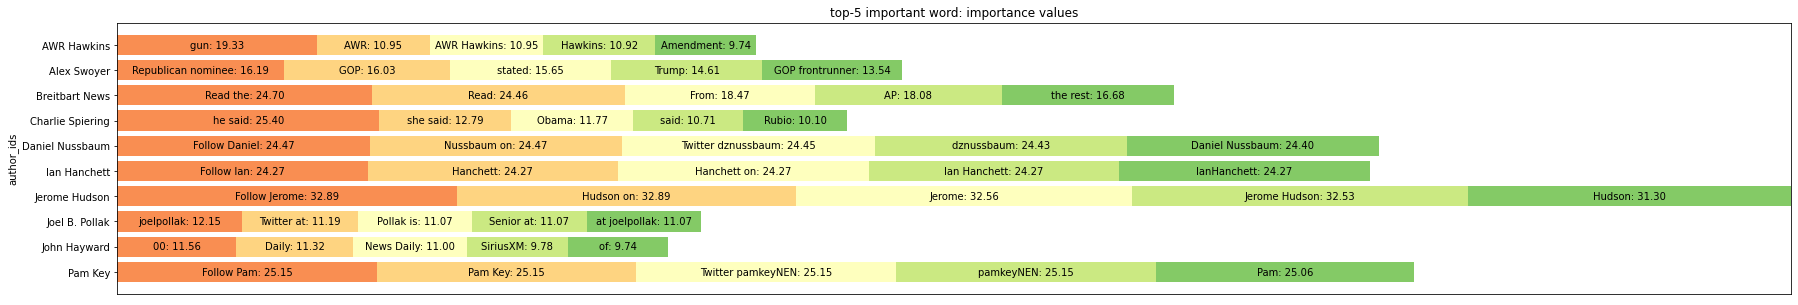

In [202]:
plot_feat_importance(word_array_sgd[:10], val_array_sgd[:10], author_names[:10], 'author_ids')

### Test on the random seed

In [ ]:
acc = []
f1 = []
for i in range(1000):
    random_seed = i
    clf = SGDClassifier(loss='log', penalty='l2', alpha=0.000001, n_iter_no_change=5, shuffle=True, random_state=random_seed)
    clf.fit(X_train, y_train)
    y_sgd = clf.predict(X_test)
    accuracy, f1_macro = eval_all(y_test, y_sgd)
    acc.append(accuracy)
    f1.append(f1_macro)

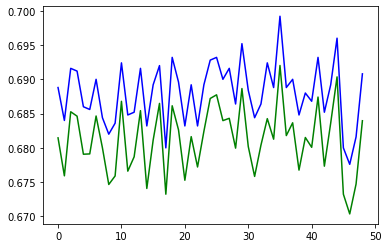

In [ ]:
plt.plot(range(49), acc, 'b')
plt.plot(range(49), f1, 'g')
plt.show()